In [1]:
import osmnx as ox
import numpy as np
import networkx as nx
import geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
import json
import folium

In [2]:
DISTANCE=5000
POINT_LAT_LON = [48.137553, 11.580008]
# network_type (string) – {‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’}
NETWORK_TYPE = 'drive'

TRIP_TIMES_MIN = [3,5,7] # TODO: TOO SHORT PRODUCING BIG POLYGONS, CHECK
SPEED_MULT = 0.8
HIGHWAY_SPEED_LIMITS ={   # copied from https://github.com/Project-OSRM/osrm-backend/blob/master/profiles/car.lua
        'motorway':90,
        'motorway_link':45,
        'trunk':85,
        'trunk_link':40,
        'primary':65,
        'primary_link':30,
        'secondary':55,
        'secondary_link':25,
        'tertiary':40,
        'tertiary_link':20,
        'unclassified':25,
        'residential':25,
        'living_street':10,
        'service':15,
        'footway': 4,    # custom
        'path': 4,       # 
        'pedestrian': 4, # 
        'steps': 2,      #
        'track': 4,      #   
        'piste': 4,      #
        'corridor': 4,   #
        'bridleway': 4,  #   
        'razed': 4,      #  
        'elevator': 0.2  #  
      }


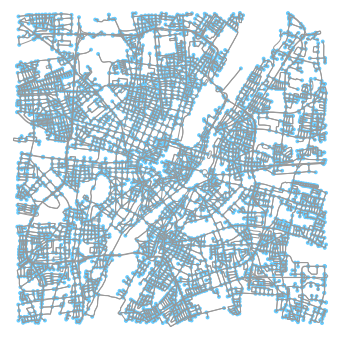

In [3]:
G = ox.graph_from_point(POINT_LAT_LON, distance=DISTANCE, network_type=NETWORK_TYPE)
fig, ax = ox.plot_graph(G)

In [4]:
for u, v, k, data in G.edges(data=True, keys=True):
    
    # if condition: some nodes don't have maxspeed, others have but are strings, others have but are a list of speeds
    if 'maxspeed' in data and type(data['maxspeed']) == str and data['maxspeed'].isdigit():
        speed_mult = int(data['maxspeed']) * SPEED_MULT # km/h
    else:
        if(type(data['highway']) == list): # sometimes data['highway'] comes with a list
            cond = [elem in HIGHWAY_SPEED_LIMITS for elem in data['highway']]
            highway_speed = data['highway'][np.where(cond)[0][0]]
        else:
            highway_speed = data['highway']
        speed_mult = HIGHWAY_SPEED_LIMITS[highway_speed] * SPEED_MULT # km/h
        
    car_meters_per_minute = speed_mult/60 * 1000       # m/min
    data['time'] = data['length']/car_meters_per_minute

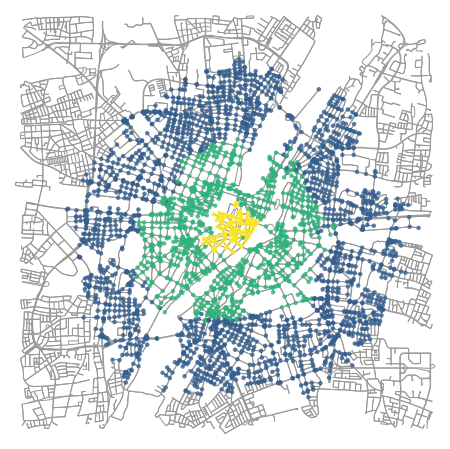

In [5]:
## distance maps

colors = ox.get_colors(n=len(TRIP_TIMES_MIN), cmap='viridis', start=0.3, return_hex=True)
node_colors = {}
center_node = ox.get_nearest_node(G, (POINT_LAT_LON[0], POINT_LAT_LON[1]))

for trip_time, color in zip(sorted([1000, 3000, 5000], reverse=True), colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=8, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=3)

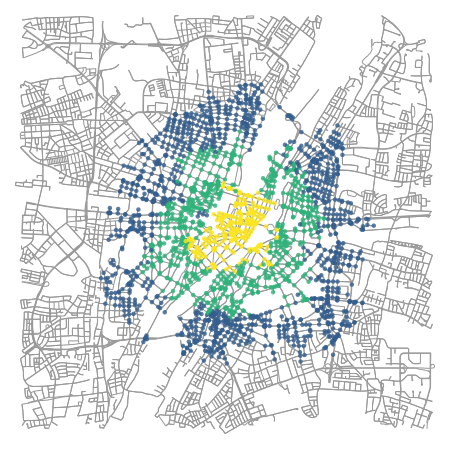

In [6]:
colors = ox.get_colors(n=len(TRIP_TIMES_MIN), cmap='viridis', start=0.3, return_hex=True)
node_colors = {}
center_node = ox.get_nearest_node(G, (POINT_LAT_LON[0], POINT_LAT_LON[1]))

for trip_time, color in zip(sorted(TRIP_TIMES_MIN, reverse=True), colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=8, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=3)

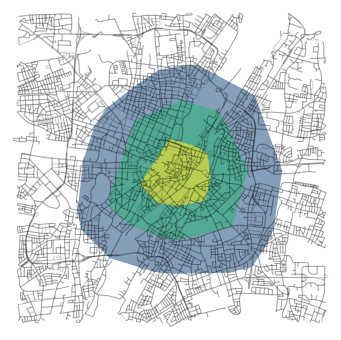

In [10]:
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')

colors = ox.get_colors(n=len(TRIP_TIMES_MIN), cmap='viridis', start=0.3, return_hex=True)
center_node = ox.get_nearest_node(G, (POINT_LAT_LON[0], POINT_LAT_LON[1]))

polygons = [] # store polygons for folium
for trip_time, color in zip(sorted(TRIP_TIMES_MIN, reverse=True), colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    polygons.append(bounding_poly)
    patch = PolygonPatch(bounding_poly, fc=color, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)

In [11]:
map_ = folium.Map(POINT_LAT_LON, zoom_start=12)

json_pols = json.loads(gpd.GeoSeries(polygons).to_json())
for elem, color, distance in zip(json_pols['features'], colors, sorted(TRIP_TIMES_MIN, reverse=True)):
    elem['properties']['style'] = {}
    elem['properties']['style']['color'] = color
    elem['properties']['style']['fillOpacity'] = .2

    temp_geo_json = folium.features.GeoJson(elem)
    temp_geo_json.add_child(folium.Popup(f'Distance: {distance} minutes'))
    temp_geo_json.add_to(map_)
            
map_           